In [19]:
#ViT tiny

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os

In [20]:
from transformers import AutoImageProcessor, AutoConfig, AutoModelForImageClassification

# Load the processor (no need to change this as it only handles preprocessing)
processor = AutoImageProcessor.from_pretrained("WinKawaks/vit-tiny-patch16-224")

# Load the configuration
config = AutoConfig.from_pretrained("WinKawaks/vit-tiny-patch16-224")
config.image_size = 128

# Initialize the model with the configuration (without pretrained weights)
model = AutoModelForImageClassification.from_config(config)

# Print the model architecture to verify
print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
classes = trainset.classes

==> Preparing data..


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].


6 - six  7 - seven  0 - zero  9 - nine


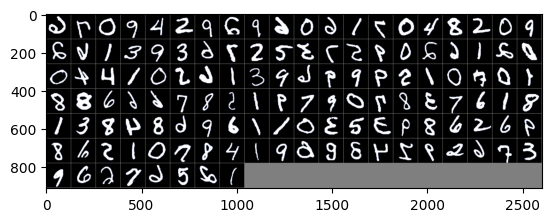

In [22]:
#view data

import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images, nrow=20)
matplotlib_imshow(img_grid, one_channel=False)
print('  '.join(classes[labels[j]] for j in range(4)))

In [23]:
print('==> Building model..')

model = model.to(device)


if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True



criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0)

==> Building model..


In [24]:
# Training
def train(epochs):
    model.train()
    for epoch in range(epochs):

        for batch_idx, (data, target) in enumerate(trainloader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            logits = output.logits
            loss = criterion(logits, target)
            #loss = nn.NLLLoss(output,target)
            loss.backward()

            optimizer.step()
            if batch_idx % 100 == 0:
                done = batch_idx * len(data)
                percentage = 100. * batch_idx / len(trainloader)
                print(f'Train Epoch: {epoch} [{done:5}/{len(trainloader.dataset)} ({percentage:3.0f}%)]  Loss: {loss.item():.6f}')

        test(trainloader)
        test(testloader)


def test(loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            logits = output.logits
            test_loss += criterion(logits, target).item() # sum up batch loss
            #test_loss += nn.NLLLoss(output, target).item()
            pred = logits.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum().item()

        test_loss /= len(loader.dataset)
        accuracy = 100. * correct / len(loader.dataset)
        print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loader.dataset)} ({accuracy:.2f}%)')
    return accuracy

In [25]:
train(50)
test(trainloader)
test(testloader)

Train Epoch: 0 [    0/60000 (  0%)]  Loss: 6.935875
Train Epoch: 0 [12800/60000 ( 21%)]  Loss: 2.276477
Train Epoch: 0 [25600/60000 ( 43%)]  Loss: 2.214394
Train Epoch: 0 [38400/60000 ( 64%)]  Loss: 2.121778
Train Epoch: 0 [51200/60000 ( 85%)]  Loss: 1.923060
Test set: Average loss: 0.0149, Accuracy: 16522/60000 (27.54%)
Test set: Average loss: 0.0189, Accuracy: 2713/10000 (27.13%)
Train Epoch: 1 [    0/60000 (  0%)]  Loss: 1.863574
Train Epoch: 1 [12800/60000 ( 21%)]  Loss: 1.847342
Train Epoch: 1 [25600/60000 ( 43%)]  Loss: 1.639934
Train Epoch: 1 [38400/60000 ( 64%)]  Loss: 1.675079
Train Epoch: 1 [51200/60000 ( 85%)]  Loss: 1.645010
Test set: Average loss: 0.0112, Accuracy: 28124/60000 (46.87%)
Test set: Average loss: 0.0140, Accuracy: 4735/10000 (47.35%)
Train Epoch: 2 [    0/60000 (  0%)]  Loss: 1.329140
Train Epoch: 2 [12800/60000 ( 21%)]  Loss: 1.294294
Train Epoch: 2 [25600/60000 ( 43%)]  Loss: 1.225179
Train Epoch: 2 [38400/60000 ( 64%)]  Loss: 1.356709
Train Epoch: 2 [51200/

92.47

In [26]:
def softmax_by_row(logits, T = 1.0):
    mx = np.max(logits, axis=-1, keepdims=True)
    exp = np.exp((logits - mx)/T)
    denominator = np.sum(exp, axis=-1, keepdims=True)
    return exp/denominator

def classifier_performance(model, train_loader, test_loader):

    output_train_benign = []
    train_label = []
    for num, data in enumerate(train_loader):
        images,labels = data
        image_tensor= images.to(device)
        img_variable = Variable(image_tensor, requires_grad=True)
        output = model.forward(img_variable)

        train_label.append(labels.numpy())
        logits = output.logits
        output_train_benign.append(softmax_by_row(logits.cpu().detach().numpy(),T = 1))


    train_label = np.concatenate(train_label)
    output_train_benign=np.concatenate(output_train_benign)

    test_label = []
    output_test_benign = []

    for num, data in enumerate(test_loader):
        images,labels = data

        image_tensor= images.to(device)
        img_variable = Variable(image_tensor, requires_grad=True)

        output = model.forward(img_variable)

        test_label.append(labels.numpy())
        logits = output.logits
        output_test_benign.append(softmax_by_row(logits.cpu().detach().numpy(),T = 1))


    test_label = np.concatenate(test_label)
    output_test_benign=np.concatenate(output_test_benign)


    train_acc1 = np.sum(np.argmax(output_train_benign,axis=1) == train_label.flatten())/len(train_label)
    test_acc1 = np.sum(np.argmax(output_test_benign,axis=1) == test_label.flatten())/len(test_label)

    print('Accuracy: ', (train_acc1, test_acc1))

    return output_train_benign, output_test_benign, train_label, test_label




def inference_via_confidence(confidence_mtx1, confidence_mtx2, label_vec1, label_vec2):
    
    #----------------First step: obtain confidence lists for both training dataset and test dataset--------------
    confidence1 = []
    confidence2 = []
    acc1 = 0
    acc2 = 0
    for num in range(confidence_mtx1.shape[0]):
        confidence1.append(confidence_mtx1[num,label_vec1[num]])
        if np.argmax(confidence_mtx1[num,:]) == label_vec1[num]:
            acc1 += 1
            
    for num in range(confidence_mtx2.shape[0]):
        confidence2.append(confidence_mtx2[num,label_vec2[num]])
        if np.argmax(confidence_mtx2[num,:]) == label_vec2[num]:
            acc2 += 1
    confidence1 = np.array(confidence1)
    confidence2 = np.array(confidence2)
    
    print('model accuracy for training and test-', (acc1/confidence_mtx1.shape[0], acc2/confidence_mtx2.shape[0]) )
    
    
    #sort_confidence = np.sort(confidence1)
    sort_confidence = np.sort(np.concatenate((confidence1, confidence2)))
    max_accuracy = 0.5
    best_precision = 0.5
    best_recall = 0.5
    for num in range(len(sort_confidence)):
        delta = sort_confidence[num]
        ratio1 = np.sum(confidence1>=delta)/confidence_mtx1.shape[0]
        ratio2 = np.sum(confidence2>=delta)/confidence_mtx2.shape[0]
        accuracy_now = 0.5*(ratio1+1-ratio2)
        if accuracy_now > max_accuracy:
            max_accuracy = accuracy_now
            best_precision = ratio1/(ratio1+ratio2)
            best_recall = ratio1
    print('membership inference accuracy is:', max_accuracy)
    return max_accuracy


In [27]:
from torch.autograd import Variable
import os
import numpy as np
import math 
import scipy
import sys  

output_train, output_test, train_label, test_label = classifier_performance(model, trainloader, testloader)
inference_accuracy=inference_via_confidence(output_train, output_test, train_label, test_label)
print("Maximum Accuracy:",inference_accuracy)

Accuracy:  (0.9493, 0.9247)
model accuracy for training and test- (0.9493, 0.9247)
membership inference accuracy is: 0.51555
Maximum Accuracy: 0.51555
